In [ ]:
!pip install torchinfo

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import pandas as pd
import torchinfo
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class ISICDataset(Dataset):
  def __init__(self,img_dir,mask_dir,image_transform=None,mask_transform=None):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.image_transform = image_transform
    self.mask_transform = mask_transform

    self.image_list = sorted(os.listdir(img_dir))
    self.mask_list = sorted(os.listdir(mask_dir))

  def __len__(self):
      return len(self.mask_list)

  def __getitem__(self,idx):

    image_name = os.path.join(self.img_dir,self.image_list[idx])
    mask_name = os.path.join(self.mask_dir,self.mask_list[idx].replace('.jpg', '.png'))

    image = Image.open(image_name).convert('RGB')
    mask = Image.open(mask_name).convert('L')

    if self.image_transform:
      image = self.image_transform(image)
    if self.mask_transform:
      mask = self.mask_transform(mask)

    return image,mask

In [ ]:
root_dir = "/content/gdrive/MyDrive/ISIC"

train_image_dir = os.path.join(root_dir,'train')
train_masks_dir = os.path.join(root_dir,'train_masks')
test_image_dir = os.path.join(root_dir,'test')
test_masks_dir = os.path.join(root_dir,'test_masks')


train_image_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_mask_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
])

test_image_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_mask_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=60),
    transforms.ToTensor(),
])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
train_dataset = ISICDataset(img_dir = train_image_dir , mask_dir = train_masks_dir,image_transform = train_image_transform,mask_transform = train_mask_transform)
test_dataset = ISICDataset(img_dir = test_image_dir , mask_dir = test_masks_dir,image_transform = test_image_transform,mask_transform = test_mask_transform)

train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)

In [ ]:
batch = next(iter(train_loader))
batch[0].size()

In [ ]:
# Print lengths of test_image_list and test_mask_list
print("Length of test_image_list:", len(train_dataset.image_list))
print("Length of test_mask_list:", len(train_dataset.mask_list))

In [ ]:
# Print lengths of test_image_list and test_mask_list
print("Length of test_image_list:", len(test_dataset.image_list))
print("Length of test_mask_list:", len(test_dataset.mask_list))

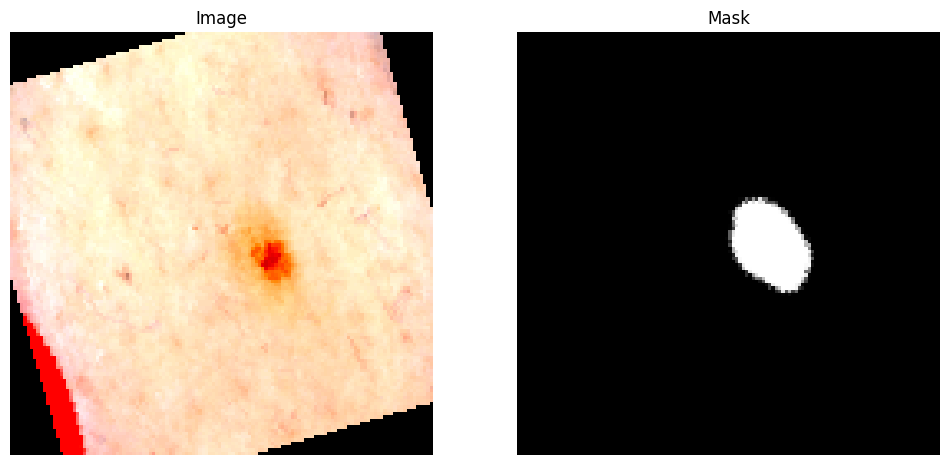

In [ ]:
def image_and_mask(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    image = image.clip(0, 1)
    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    mask = mask.clip(0, 1)
    axes[1].imshow(mask.permute(1, 2, 0),cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

for images, masks in train_loader:
    image_and_mask(images[0], masks[0])
    break

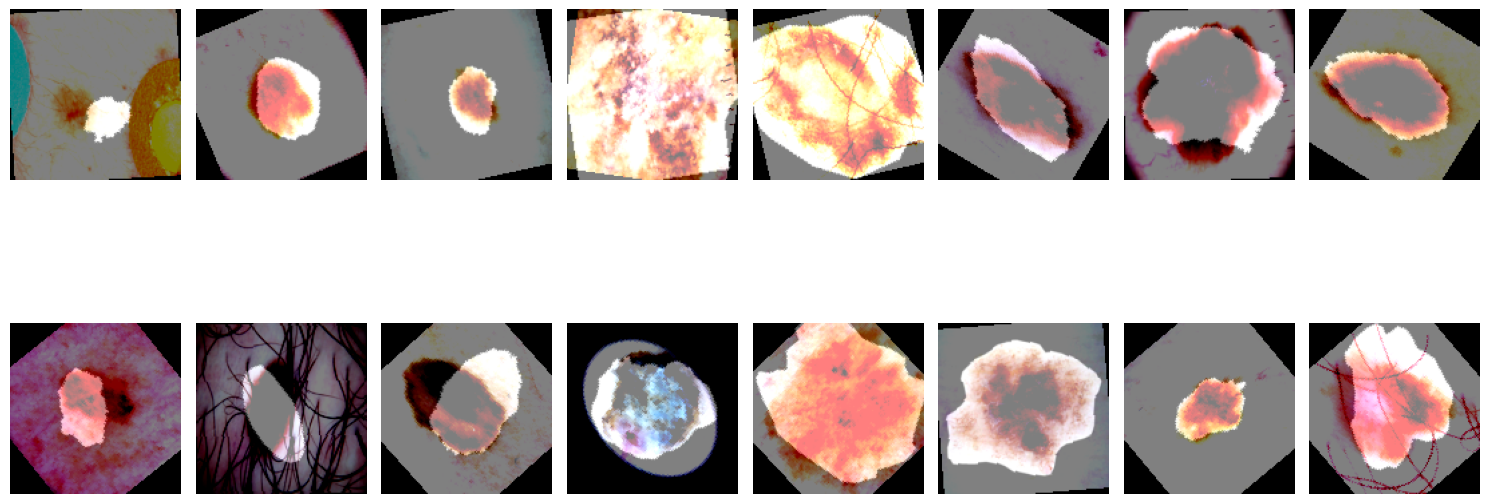

In [ ]:
def show_batch(batch):
    images, masks = batch
    batch_size = len(images)
    num_rows = 2
    num_cols = batch_size // num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0).numpy().clip(0,1)
        mask = masks[i].permute(1, 2, 0).numpy().clip(0,1)
        ax.imshow(image)
        ax.imshow(mask, alpha=0.5,cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


for batch in train_loader:
    show_batch(batch)
    break

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(1280, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU(inplace=True)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(inplace=True)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv3 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(inplace=True)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.relu4 = nn.ReLU(inplace=True)

        self.upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(16)
        self.relu5 = nn.ReLU(inplace=True)

        self.upsample5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)

        self.dropout = nn.Dropout(p=0.5)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.upsample1(x)
        x = self.dropout(x)
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.upsample2(x)
        x = self.dropout(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.upsample3(x)
        x = self.dropout(x)
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.upsample4(x)
        x = self.dropout(x)
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.upsample5(x)
        x = self.dropout(x)
        x = self.final_conv(x)
        return self.sigmoid(x)

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self,encoder,decoder):
    super(SegmentationModel,self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,x):
    features = self.encoder.features(x)
    segmentation = self.decoder(features)
    return segmentation

In [ ]:
encoder = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 65.2MB/s]


In [ ]:
for param in encoder.parameters():
  param.requires_grad=False

In [ ]:
decoder = Decoder(num_classes=1)
model1 = SegmentationModel(encoder,decoder)
torchinfo.summary(model1,input_size=[16,3,128,128])

Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationModel                                       [16, 1, 128, 128]         --
├─MobileNetV2: 1-1                                      --                        1,281,000
│    └─Sequential: 2-1                                  [16, 1280, 4, 4]          --
│    │    └─Conv2dNormActivation: 3-1                   [16, 32, 64, 64]          (928)
│    │    └─InvertedResidual: 3-2                       [16, 16, 64, 64]          (896)
│    │    └─InvertedResidual: 3-3                       [16, 24, 32, 32]          (5,136)
│    │    └─InvertedResidual: 3-4                       [16, 24, 32, 32]          (8,832)
│    │    └─InvertedResidual: 3-5                       [16, 32, 16, 16]          (10,000)
│    │    └─InvertedResidual: 3-6                       [16, 32, 16, 16]          (14,848)
│    │    └─InvertedResidual: 3-7                       [16, 32, 16, 16]          (14,848)
│    │    └─Inverte

In [ ]:
class SegmentationMetrics:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def _convert_to_binary(self, probabilities):
        binary_predictions = (probabilities > self.threshold).float()
        return binary_predictions

    def intersection_over_union(self, outputs, masks):
        predictions = self._convert_to_binary(outputs)

        intersection = torch.sum(predictions * masks)
        union = torch.sum(predictions) + torch.sum(masks) - intersection

        epsilon = 1e-6
        iou = (intersection + epsilon) / (union + epsilon)

        return iou

    def dice_score(self, outputs, masks):
        predictions = self._convert_to_binary(outputs)

        intersection = torch.sum(predictions * masks)
        dice_score = (2.0 * intersection) / (torch.sum(predictions) + torch.sum(masks))

        return dice_score

metrics = SegmentationMetrics(threshold=0.5)

In [ ]:
def visualize(image,mask,pred):
  fig,axes = plt.subplots(1,3,figsize=(15,6))
  axes[0].imshow(image.permute(1,2,0).clip(0,1))
  axes[0].set_title('Image')
  axes[0].axis('off')

  axes[1].imshow(mask.permute(1,2,0).clip(0,1),cmap='gray')
  axes[1].set_title('Ground Truth Mask')
  axes[1].axis('off')

  axes[2].imshow(pred.permute(1, 2, 0),cmap='gray')
  axes[2].set_title('Predicted Mask')
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def visualize_samples(model, test_loader, device, num_samples_to_visualize=5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_samples_to_visualize:
                break
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            pred_masks = ((outputs) > 0.5).float()
            for j in range(len(images)):
                image = images[j].cpu()
                mask = masks[j].cpu()
                pred_mask = pred_masks[j].cpu()
                visualize(image, mask, pred_mask)
                break

In [ ]:
def evaluate(model,val_loader,criterion,device):
  model.eval()
  val_running_loss = 0
  total_iou = 0
  total_dice = 0
  i = 0
  with torch.no_grad():
    for val_images,val_masks in val_loader:
      val_images = val_images.to(device)
      val_masks = val_masks.to(device)
      val_outputs = model(val_images).to(device)
      val_loss = criterion(val_outputs,val_masks)
      val_running_loss += val_loss.item()*val_images.size(0)
      pred_masks = ((val_outputs)>0.5).float()
      val_iou = metrics.intersection_over_union(pred_masks,val_masks)
      val_dice = metrics.dice_score(pred_masks,val_masks)
      total_iou += val_iou.item()*val_images.size(0)
      total_dice += val_dice.item()*val_images.size(0)
      if i==0:
        visualize(val_images[0].cpu(), val_masks[0].cpu(), pred_masks[0].cpu())
        i+=1
    val_epoch_loss = val_running_loss/len(val_loader.dataset)
    avg_iou = total_iou / len(val_loader.dataset)
    avg_dice = total_dice / len(val_loader.dataset)
    return val_epoch_loss, avg_iou, avg_dice

def train(model,train_loader,criterion,optimizer,device):
  model.train()
  train_running_loss = 0
  for train_images,train_masks in train_loader:
    train_images = train_images.to(device)
    train_masks = train_masks.to(device)
    optimizer.zero_grad()
    outputs = model(train_images).to(device)
    loss = criterion(outputs,train_masks)
    loss.backward()
    optimizer.step()
    train_running_loss+=loss.item()*train_images.size(0)
  train_epoch_loss = train_running_loss/len(train_loader.dataset)
  return train_epoch_loss

In [ ]:
def train_evaluate_model(model,train_loader,val_loader,criterion,optimizer,device,num_epochs=10):
  train_loss_history ,val_loss_history = [] , []

  for epoch in range(num_epochs):
    train_loss = train(model,train_loader,criterion,optimizer,device)
    train_loss_history.append(train_loss)
    val_loss , val_iou , val_dice = evaluate(model,val_loader,criterion,device)
    val_loss_history.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice Score: {val_dice:.4f}")

  print("")
  print(f"Dice Score : {val_dice}")
  print("")
  print(f"IOU Score : {np.mean(val_iou)}")
  print("")

  plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
  plt.plot(range(1, num_epochs+1), val_loss_history, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

  return val_dice , val_iou , train_loss , val_loss

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(),lr = 0.001)
num_epochs = 15
model1 = model1.to(device)

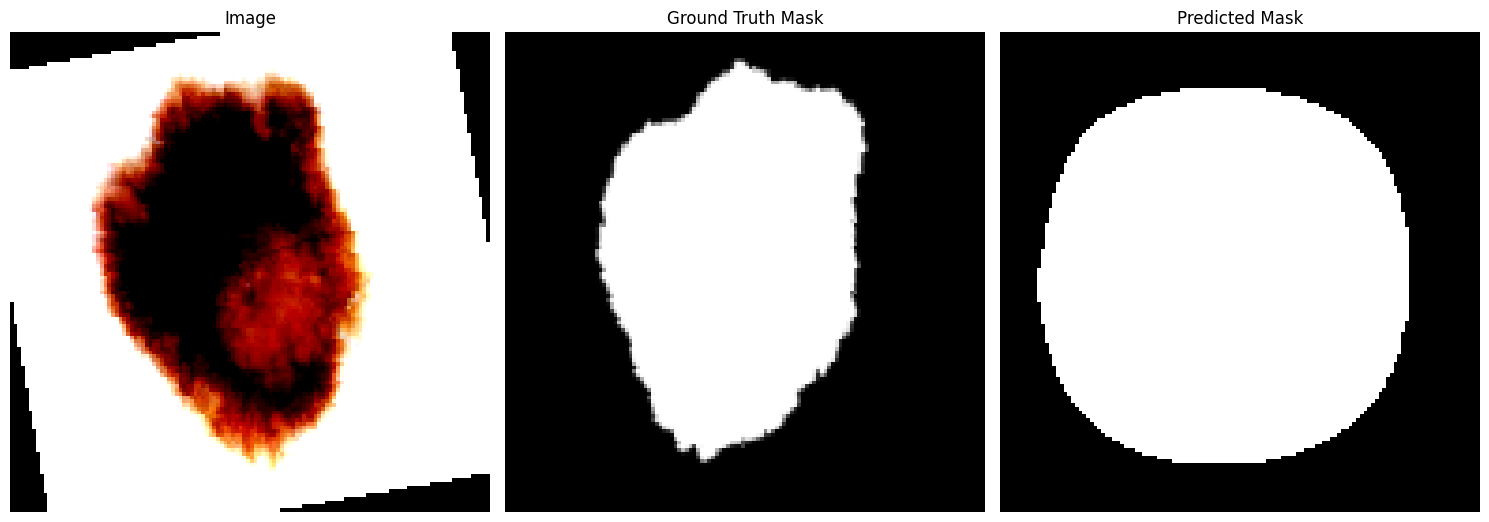

Epoch 1/15: Training Loss: 0.5255, Validation Loss: 0.4446, IoU: 0.5173, Dice Score: 0.6698


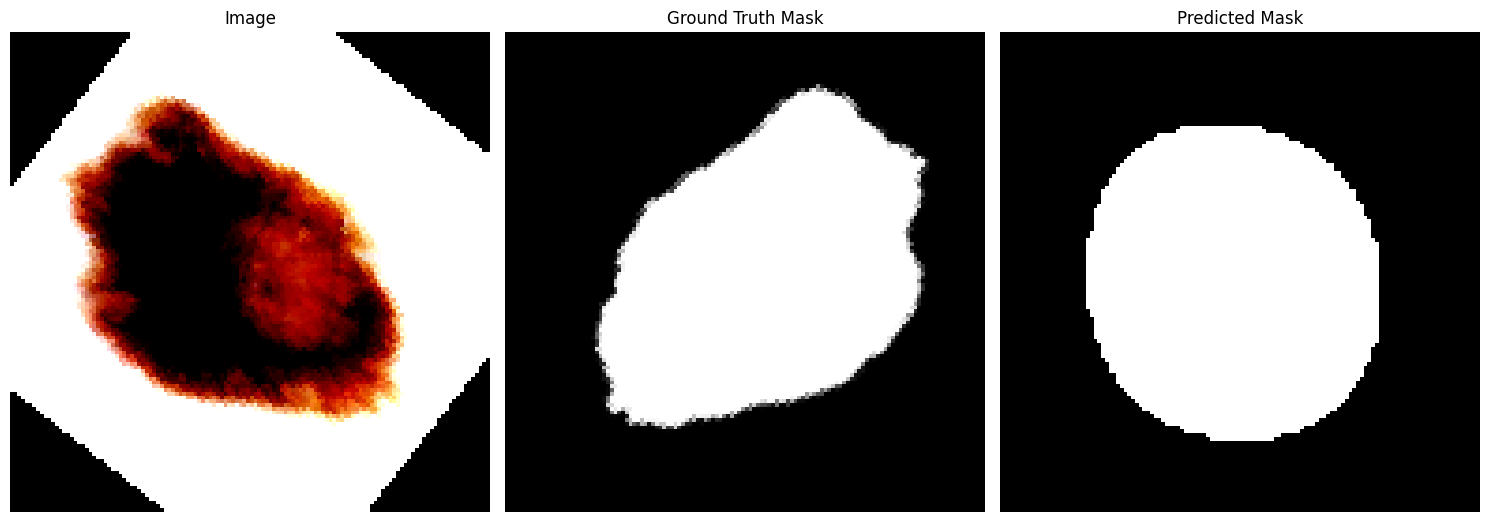

Epoch 2/15: Training Loss: 0.4071, Validation Loss: 0.3890, IoU: 0.4644, Dice Score: 0.6134


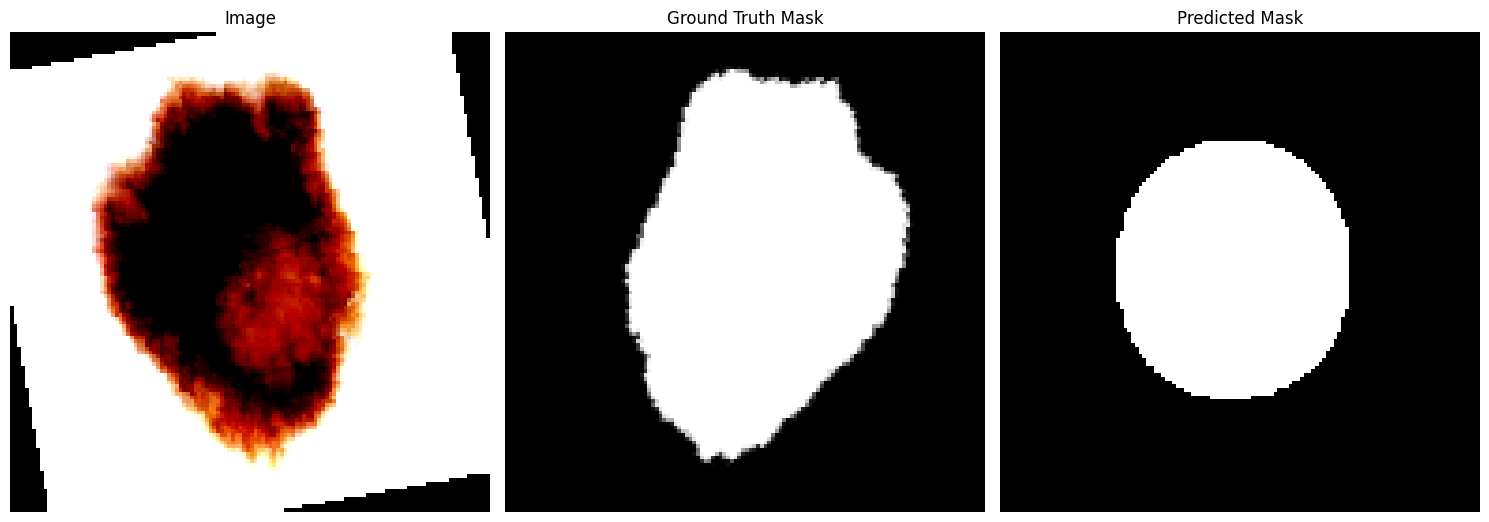

Epoch 3/15: Training Loss: 0.3520, Validation Loss: 0.3907, IoU: 0.3855, Dice Score: 0.5421


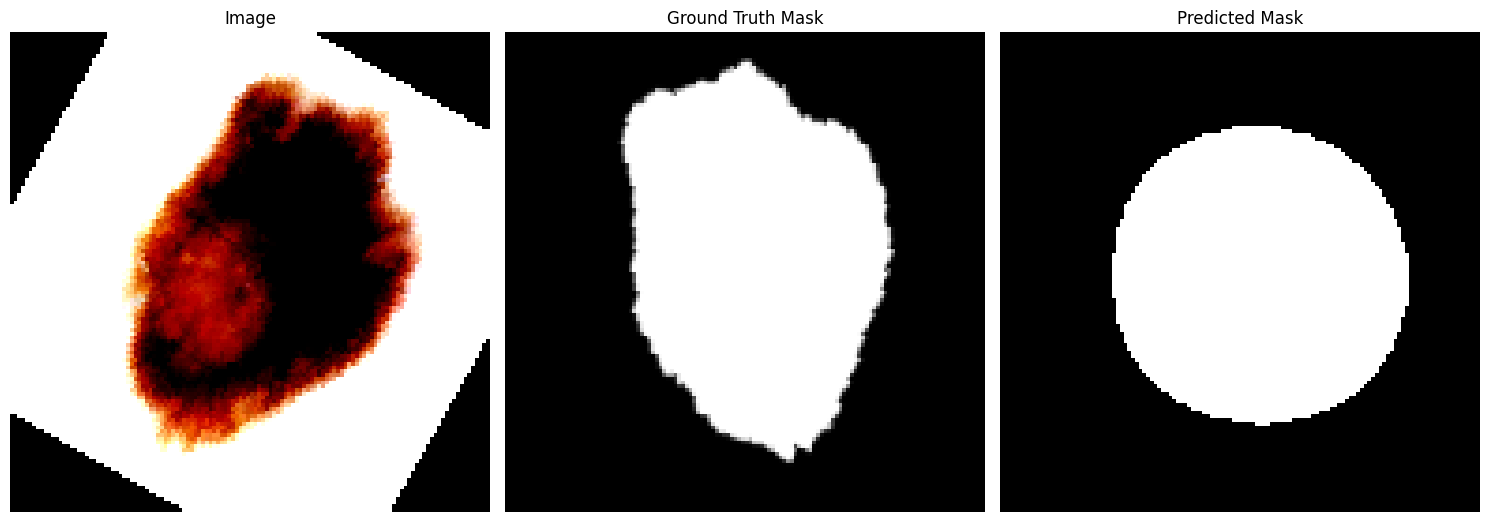

Epoch 4/15: Training Loss: 0.3302, Validation Loss: 0.3485, IoU: 0.5221, Dice Score: 0.6667


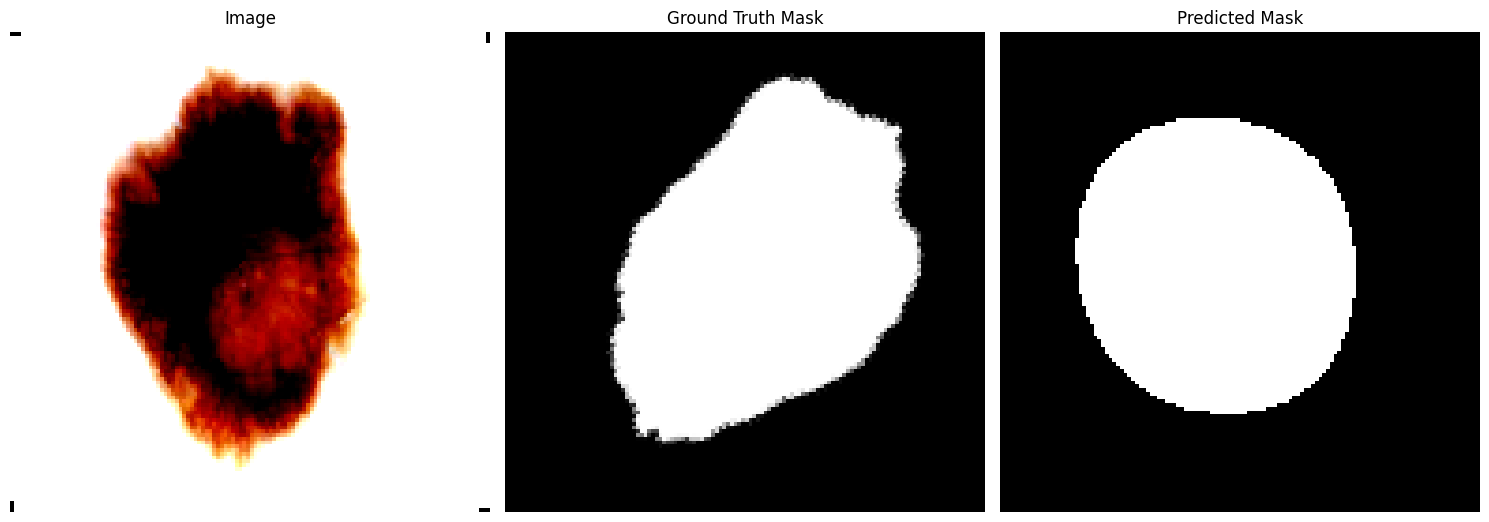

Epoch 5/15: Training Loss: 0.3222, Validation Loss: 0.3466, IoU: 0.5153, Dice Score: 0.6598


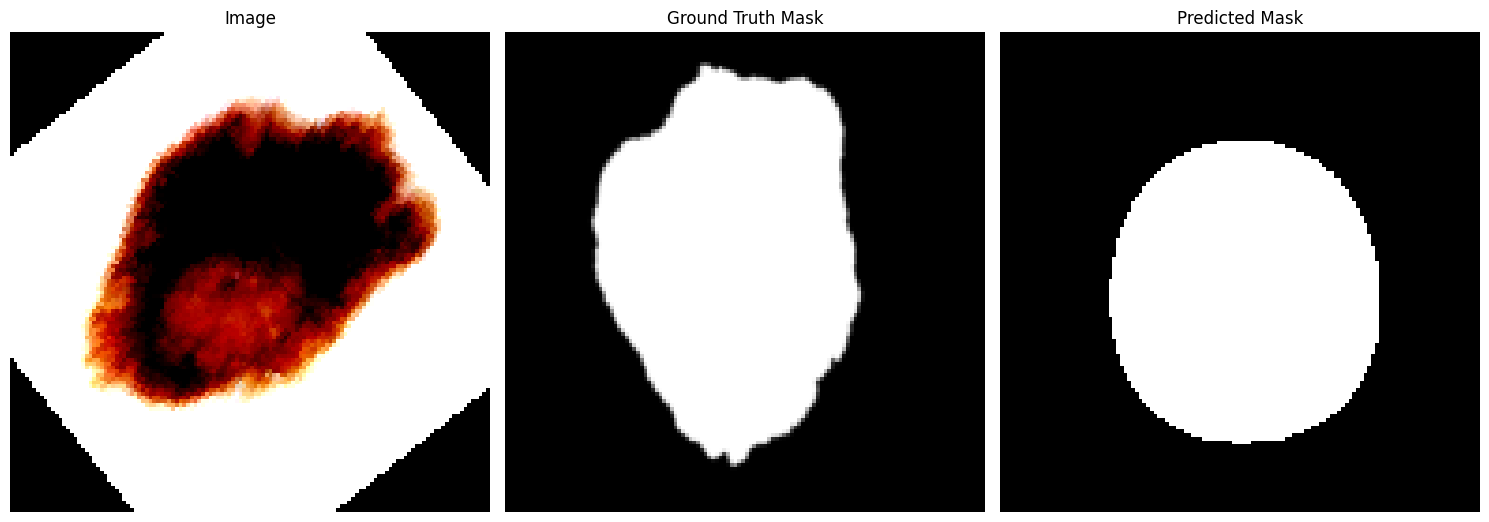

Epoch 6/15: Training Loss: 0.3051, Validation Loss: 0.3572, IoU: 0.5234, Dice Score: 0.6692


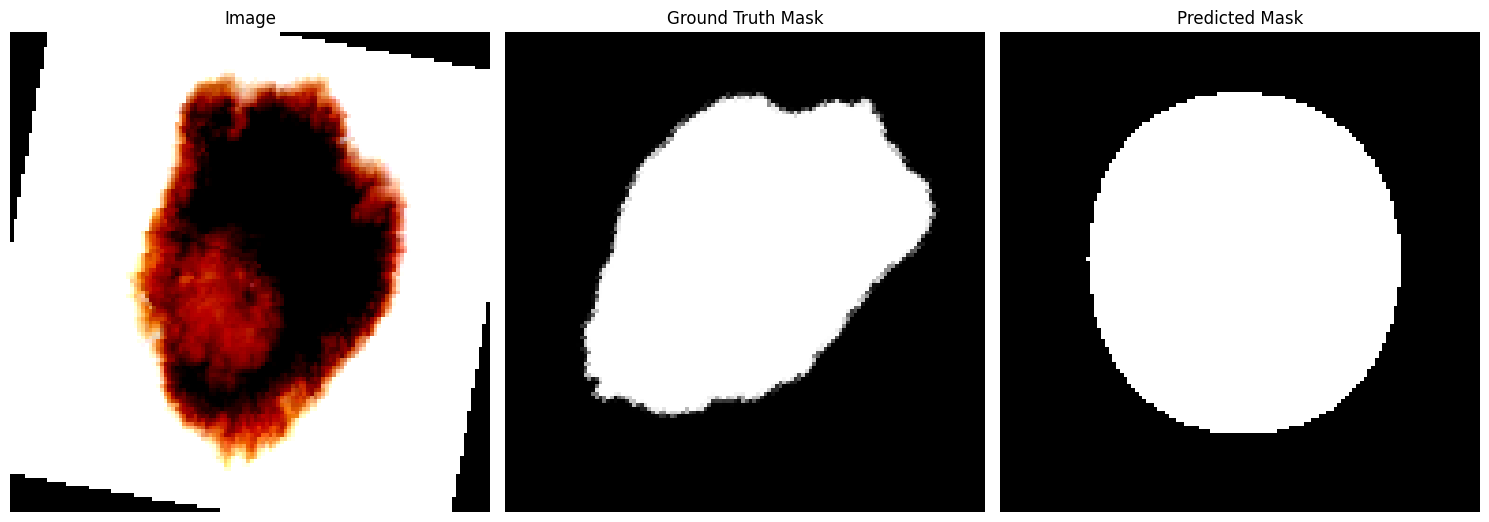

Epoch 7/15: Training Loss: 0.3064, Validation Loss: 0.3464, IoU: 0.5457, Dice Score: 0.6841


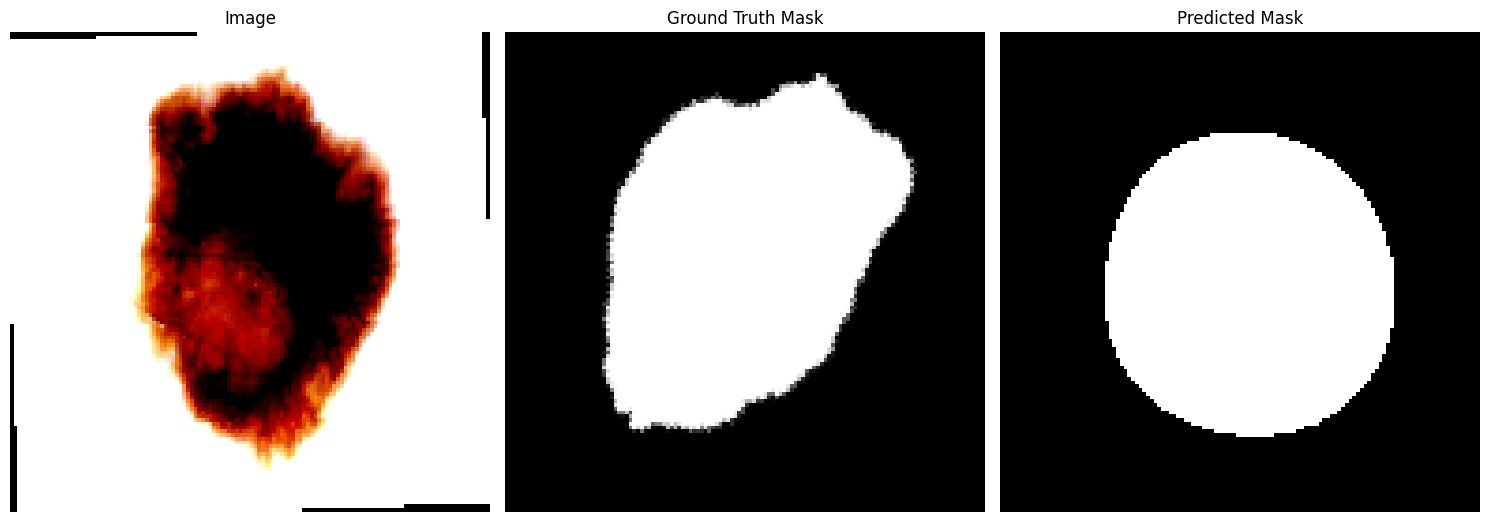

Epoch 8/15: Training Loss: 0.3019, Validation Loss: 0.3312, IoU: 0.5644, Dice Score: 0.7038


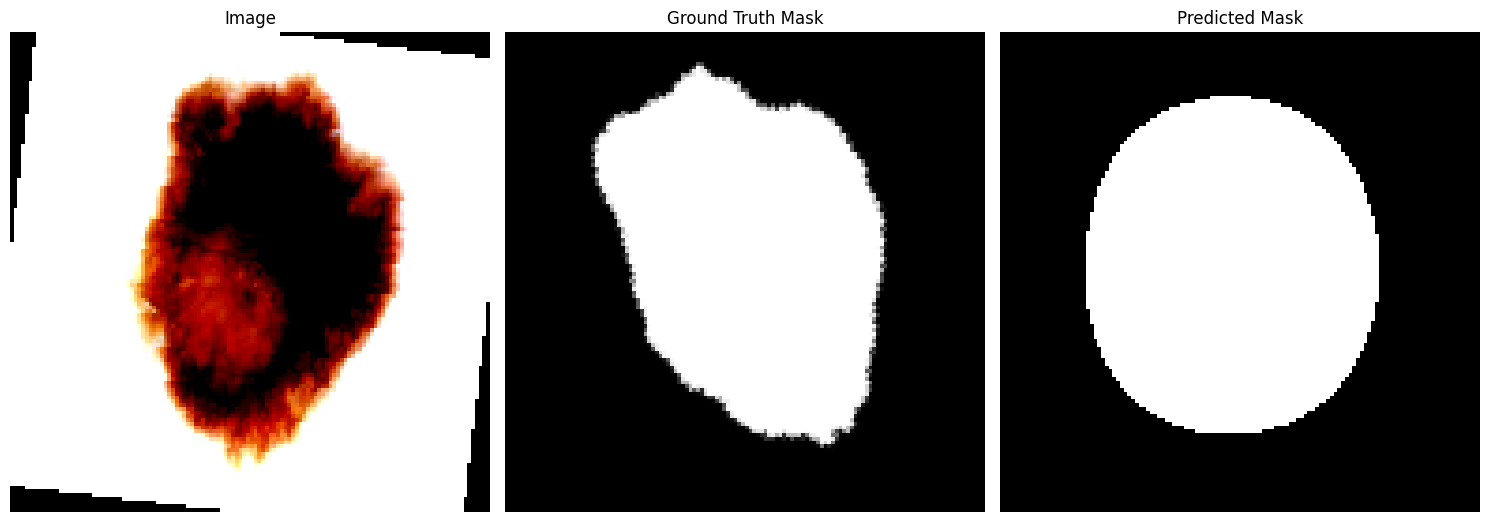

Epoch 9/15: Training Loss: 0.2873, Validation Loss: 0.3424, IoU: 0.5439, Dice Score: 0.6890


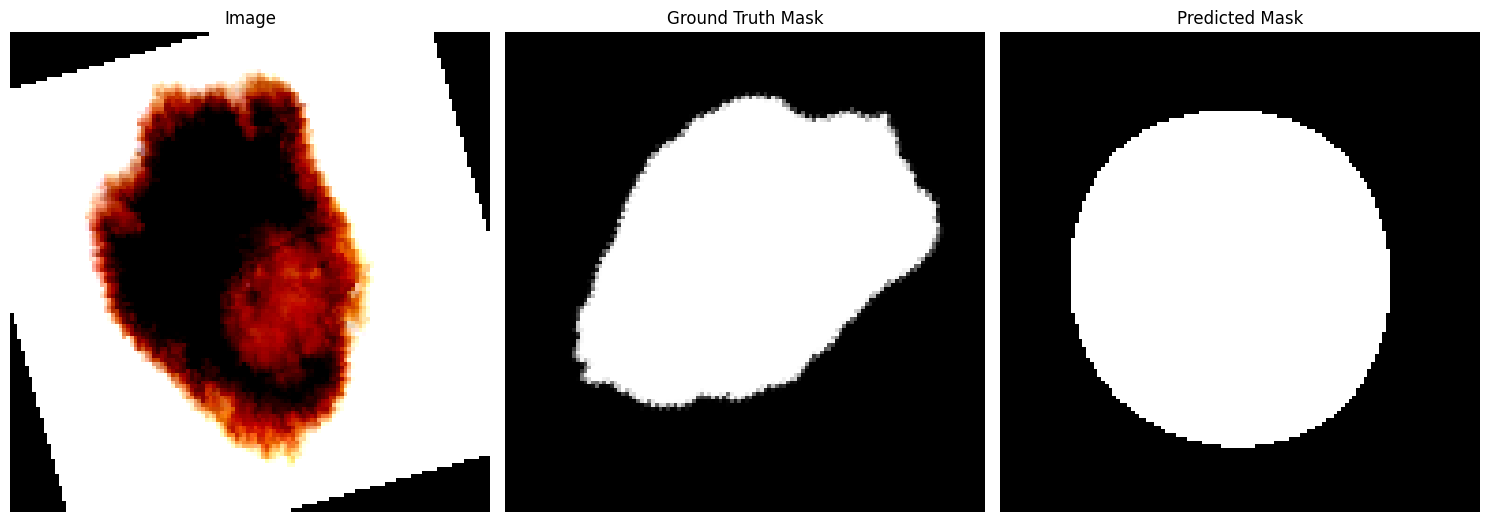

Epoch 10/15: Training Loss: 0.2872, Validation Loss: 0.3463, IoU: 0.5388, Dice Score: 0.6812


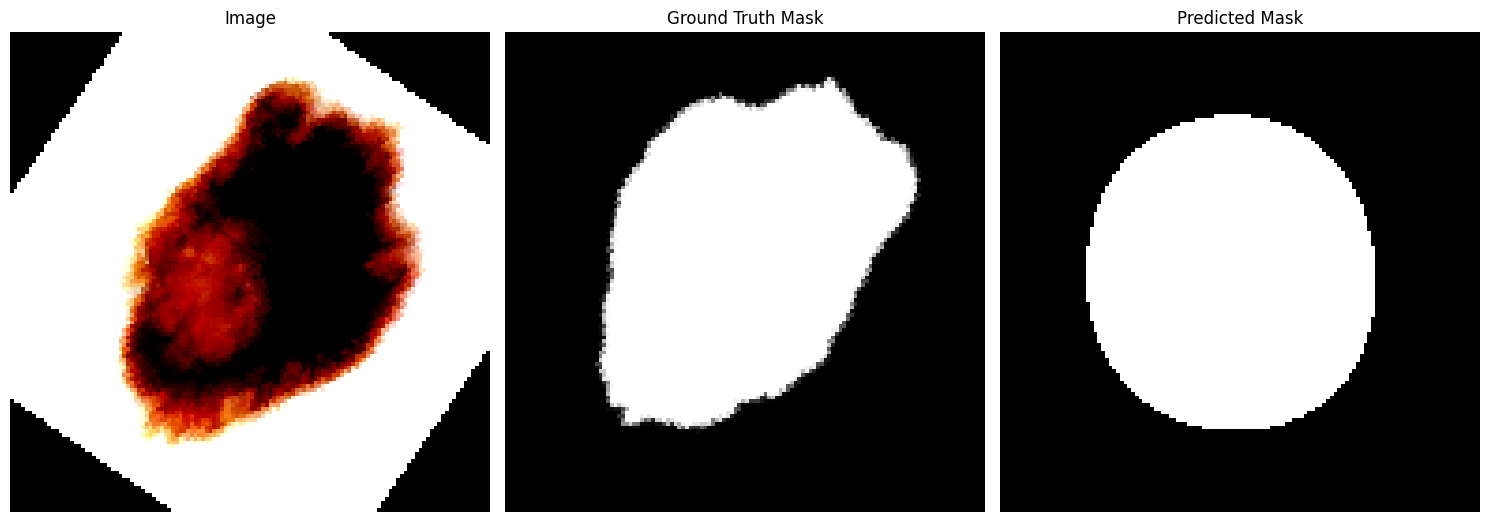

Epoch 11/15: Training Loss: 0.2797, Validation Loss: 0.3827, IoU: 0.4982, Dice Score: 0.6437


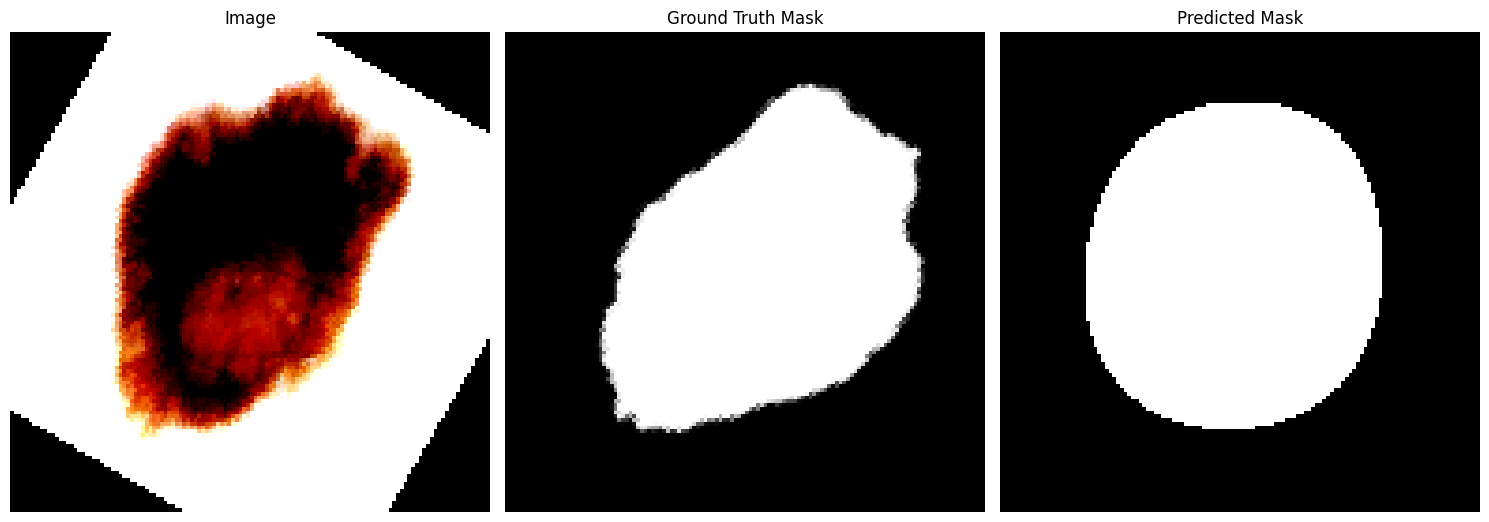

Epoch 12/15: Training Loss: 0.2832, Validation Loss: 0.3432, IoU: 0.5537, Dice Score: 0.6930


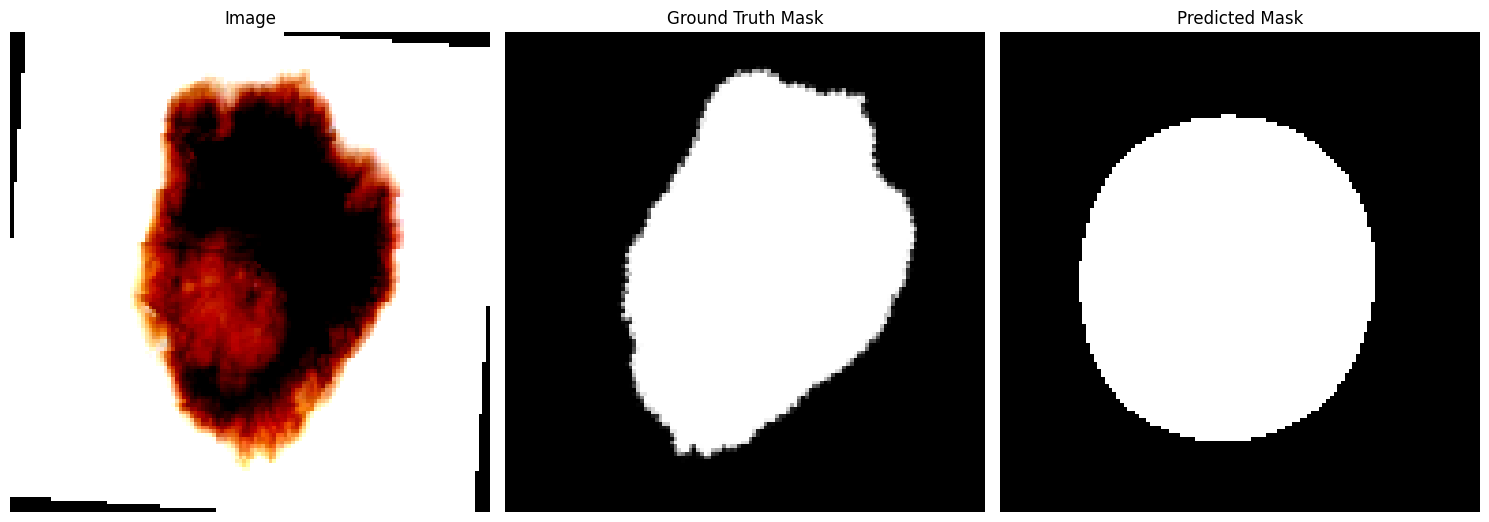

Epoch 13/15: Training Loss: 0.2846, Validation Loss: 0.3315, IoU: 0.5422, Dice Score: 0.6842


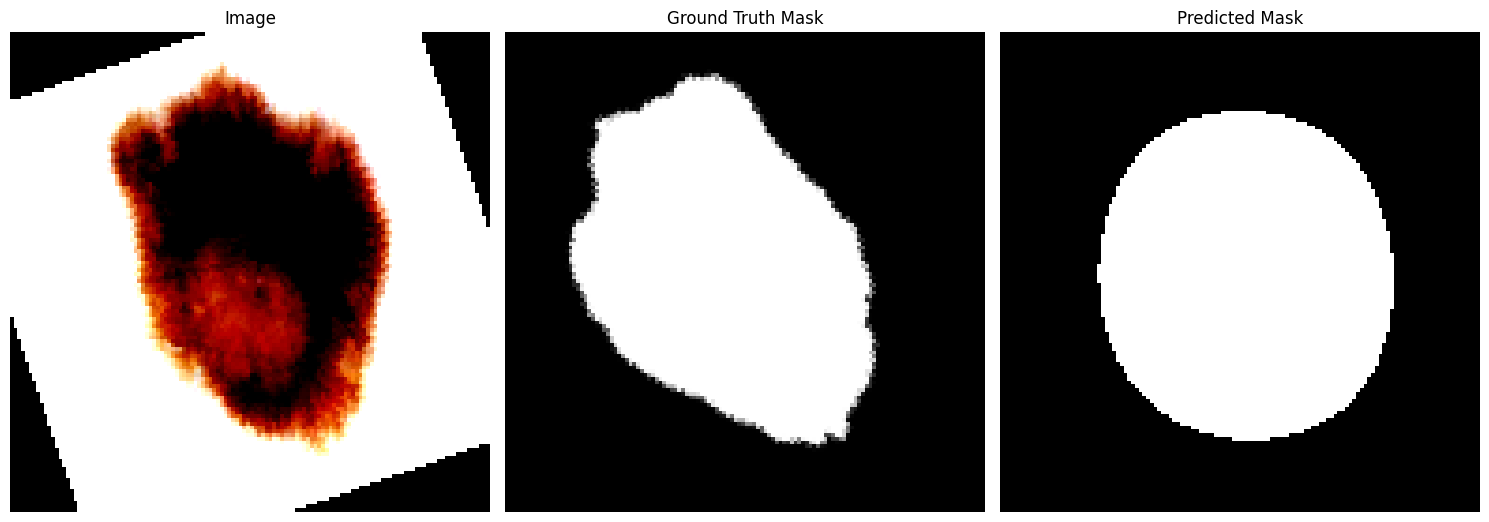

Epoch 14/15: Training Loss: 0.2728, Validation Loss: 0.3564, IoU: 0.5521, Dice Score: 0.6914


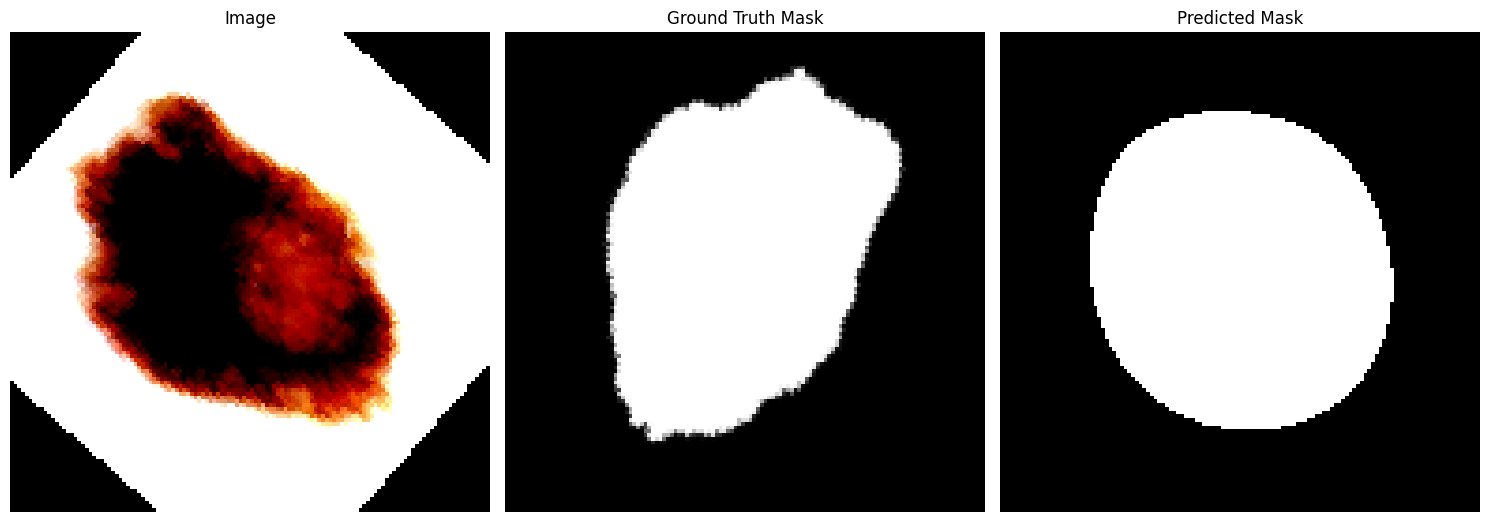

Epoch 15/15: Training Loss: 0.2772, Validation Loss: 0.3433, IoU: 0.5584, Dice Score: 0.6955

Dice Score : 0.6954816527920222

IOU Score : 0.5583779675035804



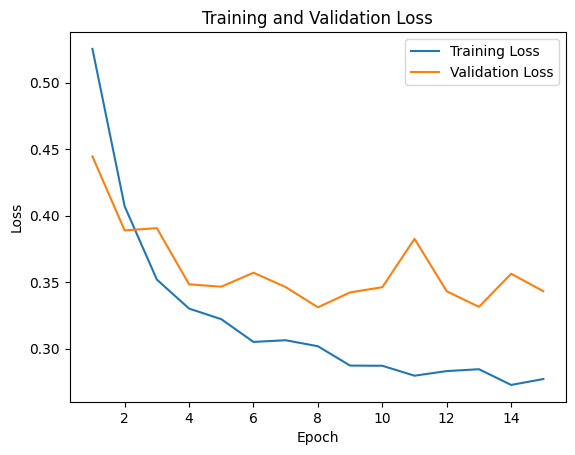

In [ ]:
task1_dice ,task1_iou , task1_train_loss , task1_val_loss = train_evaluate_model(model1, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

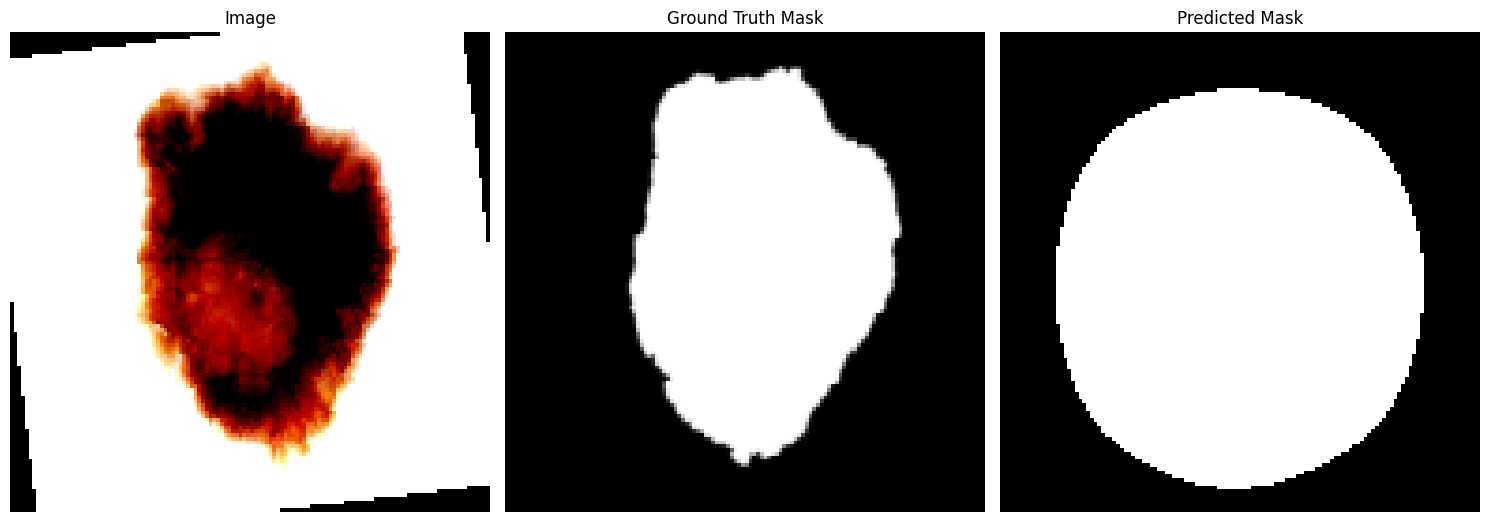

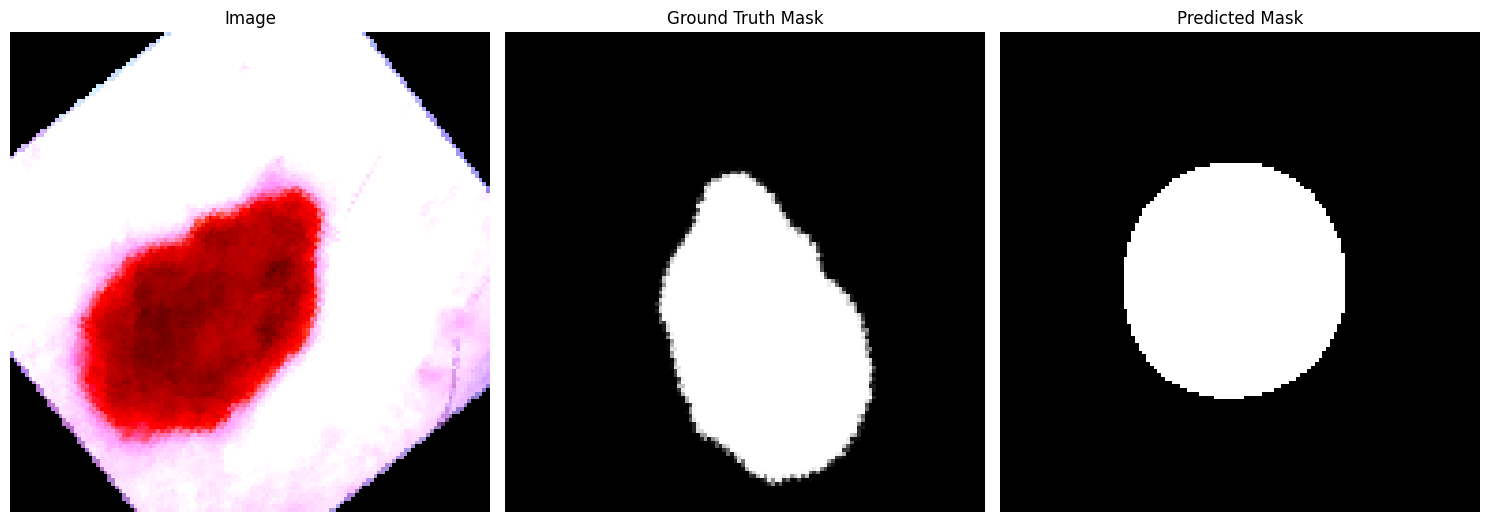

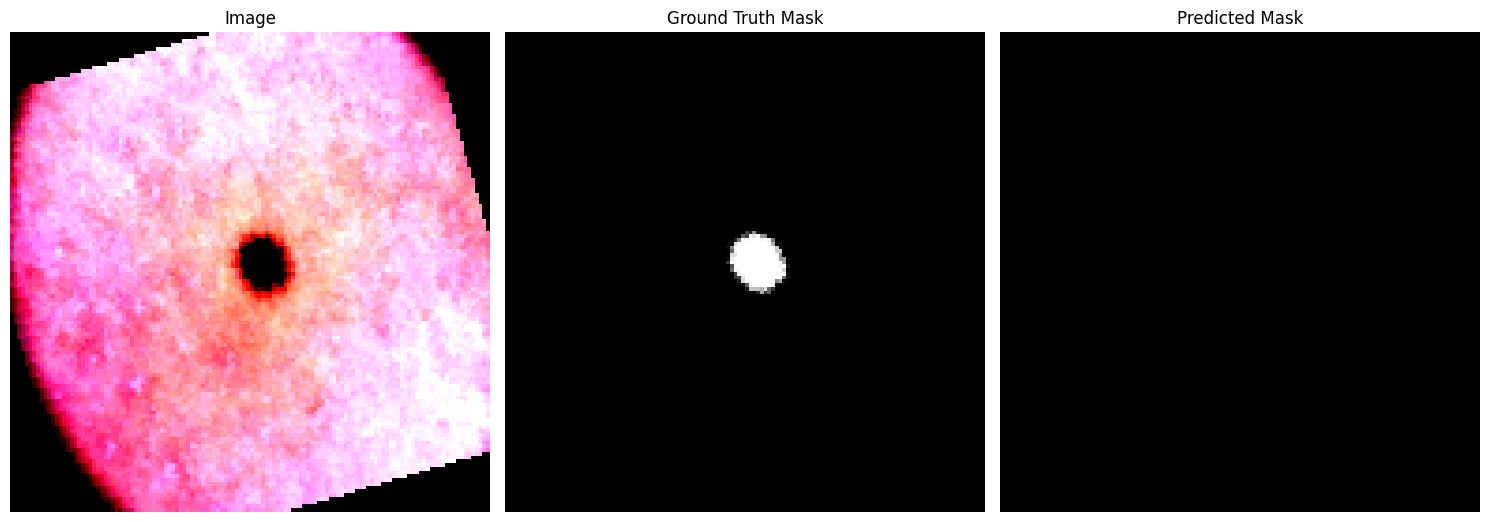

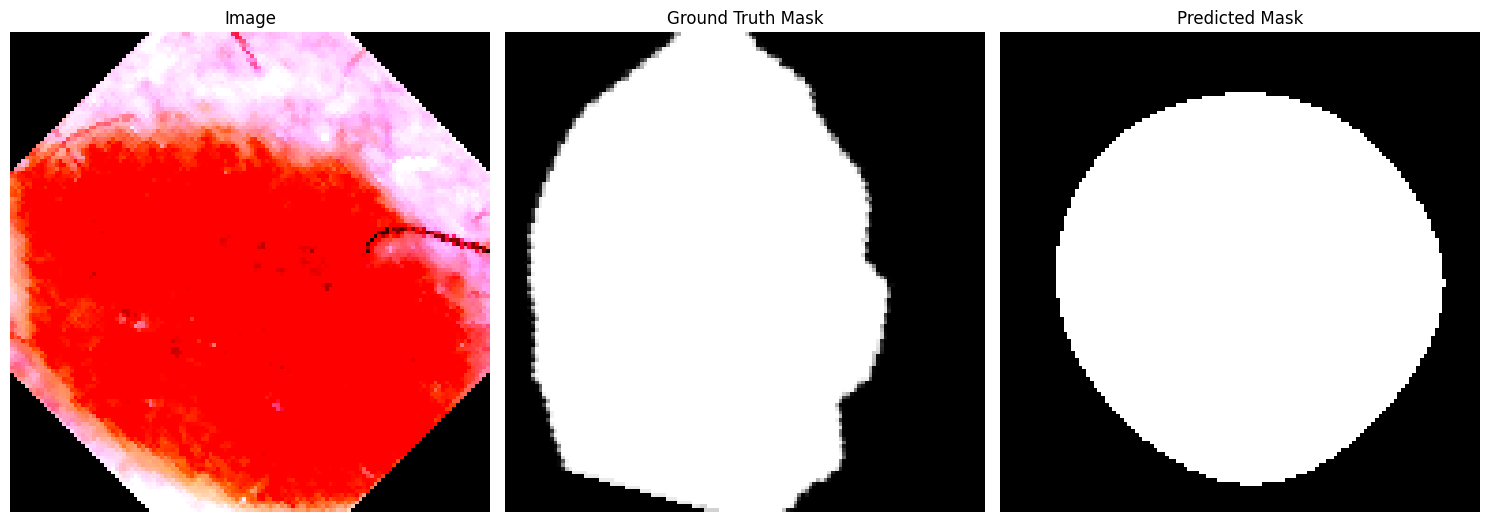

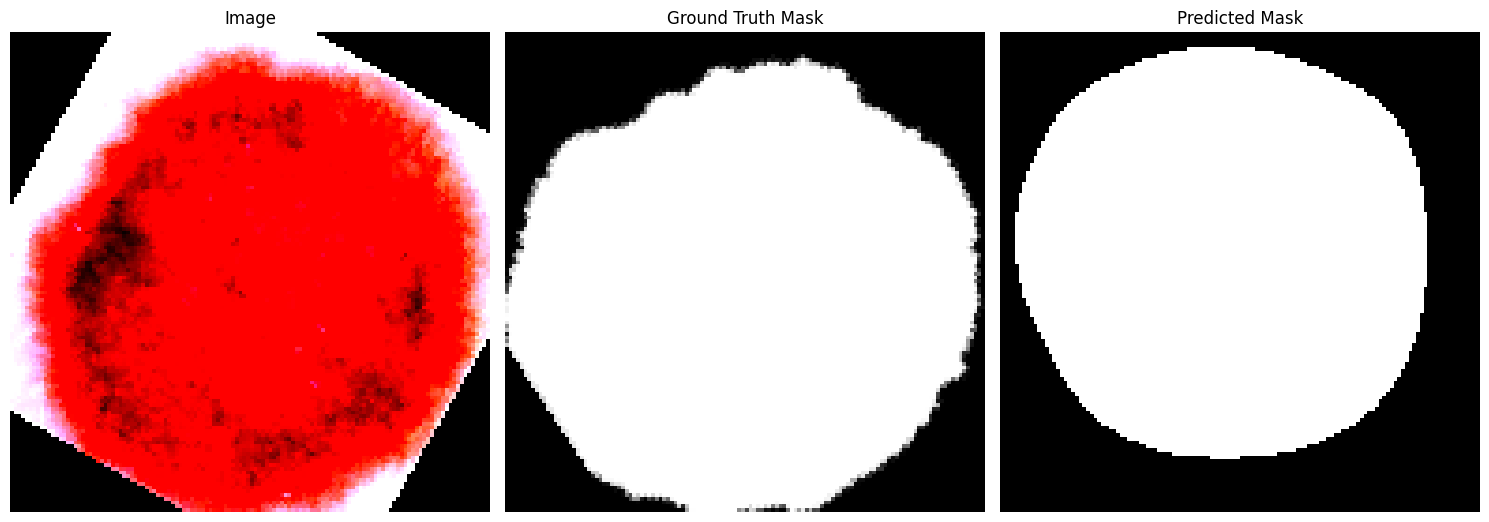

In [ ]:
visualize_samples(model1, test_loader, device, num_samples_to_visualize=5)

# Part 2

In [ ]:
encoder2 = models.mobilenet_v2(pretrained=True)

In [ ]:
for param in encoder2.parameters():
  param.requires_grad=True

In [ ]:
decoder = Decoder(num_classes=1)
model2 = SegmentationModel(encoder2, decoder)
torchinfo.summary(model2,input_size=[16,3,128,128])

Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationModel                                       [16, 1, 128, 128]         --
├─MobileNetV2: 1-1                                      --                        1,281,000
│    └─Sequential: 2-1                                  [16, 1280, 4, 4]          --
│    │    └─Conv2dNormActivation: 3-1                   [16, 32, 64, 64]          928
│    │    └─InvertedResidual: 3-2                       [16, 16, 64, 64]          896
│    │    └─InvertedResidual: 3-3                       [16, 24, 32, 32]          5,136
│    │    └─InvertedResidual: 3-4                       [16, 24, 32, 32]          8,832
│    │    └─InvertedResidual: 3-5                       [16, 32, 16, 16]          10,000
│    │    └─InvertedResidual: 3-6                       [16, 32, 16, 16]          14,848
│    │    └─InvertedResidual: 3-7                       [16, 32, 16, 16]          14,848
│    │    └─InvertedResidual: 3-8

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(),lr = 0.001)
num_epochs = 15
model2 = model2.to(device)

In [ ]:
task2_dice ,task2_iou , task2_train_loss , task2_val_loss = train_evaluate_model(model2, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

In [ ]:
visualize_samples(model2, test_loader, device, num_samples_to_visualize=5)

In [ ]:
model1_metrics = {'IoU': task1_iou, 'Dice Score': task1_dice, 'Train Loss': task1_train_loss, 'Val Loss': task1_val_loss}
model2_metrics = {'IoU': task2_iou, 'Dice Score': task2_dice, 'Train Loss': task2_train_loss, 'Val Loss': task2_val_loss}

data = {
    'Metrics': ['IoU', 'Dice Score', 'Train Loss', 'Val Loss'],
    'Model 1': [model1_metrics['IoU'], model1_metrics['Dice Score'], model1_metrics['Train Loss'], model1_metrics['Val Loss']],
    'Model 2': [model2_metrics['IoU'], model2_metrics['Dice Score'], model2_metrics['Train Loss'], model2_metrics['Val Loss']]
}

df = pd.DataFrame(data)

df

In [ ]:
metrics = ['IoU', 'Dice Score', 'Train Loss', 'Val Loss']
model1_scores = [model1_metrics['IoU'], model1_metrics['Dice Score'], model1_metrics['Train Loss'], model1_metrics['Val Loss']]
model2_scores = [model2_metrics['IoU'], model2_metrics['Dice Score'], model2_metrics['Train Loss'], model2_metrics['Val Loss']]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].bar(metrics, model1_scores, color='skyblue')
axs[0, 0].set_title('Model 1 Metrics')
axs[0, 0].set_ylabel('Scores')

axs[0, 1].bar(metrics, model2_scores, color='salmon')
axs[0, 1].set_title('Model 2 Metrics')

bar_width = 0.35

x = np.arange(len(metrics[:2]))
axs[1, 0].bar(x - bar_width/2, [model1_metrics['IoU'], model1_metrics['Dice Score']], width=bar_width, color='skyblue', label='Model 1')
axs[1, 0].bar(x + bar_width/2, [model2_metrics['IoU'], model2_metrics['Dice Score']], width=bar_width, color='salmon', label='Model 2')
axs[1, 0].set_title('Comparison of IoU and Dice Score')
axs[1, 0].set_ylabel('Scores')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(metrics[:2])
axs[1, 0].legend()

x = np.arange(len(metrics[2:]))
axs[1, 1].bar(x - bar_width/2, [model1_metrics['Train Loss'], model1_metrics['Val Loss']], width=bar_width, color='skyblue', label='Model 1')
axs[1, 1].bar(x + bar_width/2, [model2_metrics['Train Loss'], model2_metrics['Val Loss']], width=bar_width, color='salmon', label='Model 2')
axs[1, 1].set_title('Comparison of Train and Val Loss')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(metrics[2:])
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
max_value = max(max(model1_metrics.values()), max(model2_metrics.values()))
model1_values_norm = [model1_metrics[metric] / max_value for metric in metrics]
model2_values_norm = [model2_metrics[metric] / max_value for metric in metrics]

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()

model1_values_norm += model1_values_norm[:1]
model2_values_norm += model2_values_norm[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, model1_values_norm, color='skyblue', alpha=0.25, label='Model 1')
ax.fill(angles, model2_values_norm, color='salmon', alpha=0.25, label='Model 2')

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.title('Comparison of Metrics Using Radar Chart')
plt.show()